# Bundesliga 2023–2024: Calculating Match Odds Using PCA, KMeans and Random Forest Classifier

The goal of this project is to emulate the way bookies assign odds to match results. 

For this purpose, Bundesliga data is used.

Team stats and match results are taken from the https://fbref.com website. 

Notes: The data is taken directly from the page using web scraping. If you want to replicate the code and get the exact same results, you need to use the xlsx files that are in the repo (merged_df_bundes, games_bundes, baseprueba2_bundes). If you run the code not using those files, you will get different results because, at this time, it is half-season and as games continue, stats and match results will be updated. At the same time, the accuracy of the model should be higher in the end stages of the season and lower at the beginning, so it is better to make the calculations after around the first 8 or more week games. Last but not least, if you want to know the meaning of each variable in fbref data you should visit the website.

Last but not least, if you want to know the meaning of each variable in the fbref data, you should visit the website.

First, load the Python modules that are going to be needed:

In [1]:
pip install scrapy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from scrapy import Selector
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

The next cells contain custom functions that I will use later in the code:

In [3]:
def conexion_fbref_page(url):
    # Send a GET request to the website and retrieve the HTML content
    response = requests.get(url)

    # Create a Selector object from the HTML content
    selector = Selector(text=response.text)
    #return selector
    return selector
    

In [4]:
def tableScraper(sel, idt):
    '''
    sel = Selector
    idt = table Id from html
    '''
    # Use XPath or CSS selectors to locate the table element on the webpage
    table_xpath = "//table[@id='"+idt+"']"

    # Extract the table element using the XPath
    table_element = sel.xpath(table_xpath).get()  

    # Use pandas to read the HTML table into a DataFrame
    df = pd.read_html(table_element)[0]

    # Display the DataFrame
    return df

In [5]:
#Function to transform the last 5 games results into points
def resultPoints(value):
    val = [c for c in value]
    val1 = [3 if c == 'W' else c for c in val]
    val2 = [1 if c == 'D' else c for c in val1]
    val3 = [0 if c == 'L' else c for c in val2]
    val4 = [0 if c == ' ' else c for c in val3]
    va5 = [int(v) for v in val4]
    return sum(val4)

In [6]:
#Function to rename the of a dataframe that has column names in tuples
def colNames(df):
    colNames = [c[1] for c in df.columns]
    df.columns = colNames
    return df
    

In [7]:
def summaryTeam(team, df, clust, TeamClust):
    try:
        team = team.capitalize()
        dfTeam = df[(df['Home'] == team) | (df['Away'] == team)]
    except:
        print('Please introduce a valid name for a Serie A Team')
    clusterTeam = TeamClust #extract the team's cluster
    # All
    # Home
    try:
        HomeWins = dfTeam[dfTeam['Home'] == team]['Result'].value_counts()['H'] #total home wins
    except:
        HomeWins = 0
    try:
        HomeLoses = dfTeam[dfTeam['Home'] == team]['Result'].value_counts()['A'] #total home defeats
    except:
        HomeLoses = 0
    try:
        HomeDraws = dfTeam[dfTeam['Home'] == team]['Result'].value_counts()['D'] #total home draws
    except:
        HomeDraws = 0
    try:
        HomeWinsP = HomeWins/(HomeWins+HomeLoses+HomeDraws) #proportion of Home wins as fraction of total home matches
    except:
        HomeWinsP = 0
    try:
        HomeLosesP = HomeLoses/(HomeWins+HomeLoses+HomeDraws) #proportion of Home defeats as fraction of total home matches
    except:
        HomeLosesP = 0
    try:
        HomeDrawsP = HomeDraws/(HomeWins+HomeLoses+HomeDraws) #proportion of Home draws as fraction of total home matches
    except:
        HomeDrawsP = 0
        #goals
    try:
        HomeGScore = dfTeam[dfTeam['Home'] == team]['homeScore'].sum() #Home goals scored
    except:
        HomeGScore = 0
    try:
        HomeGReceive = dfTeam[dfTeam['Home'] == team]['awayScore'].sum() #Home goals received
    except:
        HomeGReceive = 0
    
    
    # Away
    try:
        AwayWins = dfTeam[dfTeam['Away'] == team]['Result'].value_counts()['A'] #total away wins
    except:
        AwayWins = 0
    try:
        AwayLoses = dfTeam[dfTeam['Away'] == team]['Result'].value_counts()['H'] #total away defeats
    except:
        AwayLoses = 0
    try:
        AwayDraws = dfTeam[dfTeam['Away'] == team]['Result'].value_counts()['D'] #total away draws
    except:
        AwayDraws = 0
    try:
        AwayWinsP = AwayWins/(AwayWins+AwayLoses+AwayDraws) #proportion of away wins as fraction of total away matches
    except:
        AwayWinsP = 0
    try:
        AwayLosesP = AwayLoses/(AwayWins+AwayLoses+AwayDraws) #proportion of away defeats as fraction of total away matches
    except:
        AwayLosesP = 0
    try:
        AwayDrawsP = AwayDraws/(AwayWins+AwayLoses+AwayDraws) #proportion of away draws as fraction of total away matches
    except:
        AwayDrawsP = 0
        #goals
    try:
        AwayGScore = dfTeam[dfTeam['Away'] == team]['awayScore'].sum() #away goals scored
    except:
        AwayGScore = 0
    try:
        AwayGReceive = dfTeam[dfTeam['Away'] == team]['homeScore'].sum() #away goals received
    except:
        AwayGReceive = 0
        
        
    
    # Overall
    OverAllWins = HomeWins + AwayWins #overall wins
    try:
        OverAllWinsP = OverAllWins/(HomeWins + AwayWins + HomeLoses + AwayLoses + HomeDraws + AwayDraws)
    except:
        OverAllWinsP = 0 #overall wins proportion as fraction of total matches
        
    OverAllLoses = HomeLoses + AwayLoses #overall defeats
    try:
        OverAllLosesP = OverAllLoses/(HomeWins + AwayWins + HomeLoses + AwayLoses + HomeDraws + AwayDraws)
    except:
        OverAllLosesP = 0 #overall defeats proportion as fraction of total matches
        
    OverAllDraws = HomeDraws + AwayDraws # overall draws
    try:
        OverAllDrawsP = OverAllDraws/(HomeWins + AwayWins + HomeLoses + AwayLoses + HomeDraws + AwayDraws)
    except:
        OverAllDrawsP = 0 # overall draws proportion as fraction of total matches
    #goals
    OverAllGScore = HomeGScore+AwayGScore #overall goals scored
    OverAllGReceive = AwayGReceive + HomeGReceive #overall goals received
    
    simplePerformance = {
        'HomeWinsS': HomeWins,
        'HomeWinsSP':HomeWinsP,
        'HomeLosesS': HomeLoses,
        'HomeLosesSP':HomeLosesP,
        'HomeDrawsS': HomeDraws,
        'HomeDrawsSP':HomeDrawsP,
        'AwayWinsS': AwayWins,
        'AwayWinsSP': AwayWinsP,
        'AwayLosesS': AwayLoses,
        'AwayLosesSP': AwayLosesP,
        'AwayDrawsS': AwayDraws,
        'AwayDrawsSP': AwayDrawsP,
        'OverAllWinsS': OverAllWins,
        'OverAllWinsSP':OverAllWinsP,
        'OverAllLosesS': OverAllLoses,
        'OverAllLosesSP': OverAllLosesP,
        'OverAllDrawsS': OverAllDraws,
        'OverAllDrawsSP':OverAllDrawsP,
        'HomeGScoreS':HomeGScore,
        'HomeGReceiveS':HomeGReceive,
        'AwayGScoreS':AwayGScore,
        'AwayGReceiveS':AwayGReceive,
        'OverAllGScoreS':OverAllGScore,
        'OverAllGReceiveS':OverAllGReceive
        
    }
    
    #clusters
    clustersPerformance = {}
    for c in clust:
        # Home
        HomeMatchesC = len(dfTeam[(dfTeam['Home'] == team) & (dfTeam['AwayCluster'] == c)]) #home matches vs all clusters
        try:
            HomeWinsC = dfTeam[(dfTeam['Home'] == team) & (dfTeam['AwayCluster'] == c)]['Result'].value_counts()['H']
        except:
            HomeWinsC = 0 #home wins vs all clusters
        try:
            HomeWinsCP = HomeWinsC/HomeMatchesC #home wins proportion vs all clusters
        except:
            HomeWinsCP = 0
        try:
            HomeLosesC = dfTeam[(dfTeam['Home'] == team) & (dfTeam['AwayCluster'] == c)]['Result'].value_counts()['A']
        except:
            HomeLosesC = 0 #home defeats vs all clusters
        try:
            HomeLosesCP = HomeLosesC/HomeMatchesC #home defeats proportion vs all clusters
        except:
            HomeLosesCP = 0
        try:
            HomeDrawsC = dfTeam[(dfTeam['Home'] == team) & (dfTeam['AwayCluster'] == c)]['Result'].value_counts()['D']
        except:
            HomeDrawsC = 0 #home draws vs all clusters
        try:
            HomeDrawsCP = HomeDrawsC/HomeMatchesC #home draws proportion vs all clusters
        except:
            HomeDrawsCP = 0
        
            #goals
        try:
            HomeGScoreC = dfTeam[(dfTeam['Home'] == team) & (dfTeam['AwayCluster'] == c)]['homeScore'].sum()
        except:
            HomeGScoreC = 0 #home goals scored vs all clusters
        try:
            HomeGReceiveC = dfTeam[(dfTeam['Home'] == team) & (dfTeam['AwayCluster'] == c)]['awayScore'].sum()
        except:
            HomeGReceiveC = 0 #home goals received vs all clusters
        
        
        # Away
        AwayMatchesC = len(dfTeam[(dfTeam['Away'] == team) & (dfTeam['HomeCluster'] == c)]) #away matches vs all clusters
        try:
            AwayWinsC = dfTeam[(dfTeam['Away'] == team) & (dfTeam['HomeCluster'] == c)]['Result'].value_counts()['A']
        except:
            AwayWinsC = 0 #away wins vs all clusters
        try:
            AwayWinsCP = AwayWinsC/AwayMatchesC #away wins proportion vs all clusters
        except:
            AwayWinsCP = 0
        try:
            AwayLosesC = dfTeam[(dfTeam['Away'] == team) & (dfTeam['HomeCluster'] == c)]['Result'].value_counts()['H']
        except:
            AwayLosesC = 0 #away defeats vs all clusters
        try:
            AwayLosesCP = AwayLosesC/AwayMatchesC #away defeats proportion vs all clusters
        except:
            AwayLosesCP = 0
        try:
            AwayDrawsC = dfTeam[(dfTeam['Away'] == team) & (dfTeam['HomeCluster'] == c)]['Result'].value_counts()['D']
        except:
            AwayDrawsC = 0 #away draws vs all clusters
        try:
            AwayDrawsCP = AwayDrawsC/AwayMatchesC #away draws proportion vs all clusters
        except:
            AwayDrawsCP = 0
            
            #goals
        try:
            AwayGScoreC = dfTeam[(dfTeam['Away'] == team) & (dfTeam['HomeCluster'] == c)]['awayScore'].sum()
        except:
            AwayGScoreC = 0 #away goals scored vs all clusters
        try:
            AwayGReceiveC = dfTeam[(dfTeam['Away'] == team) & (dfTeam['HomeCluster'] == c)]['homeScore'].sum()
        except:
            AwayGReceiveC = 0 #away goals received vs all clusters
        
        
        # Overall
        OverAllMatchesC = HomeMatchesC + AwayMatchesC #overall matches vs all clusters
        OverAllWinsC = HomeWinsC + AwayWinsC #overall wins vs all clusters
        try:
            OverAllWinsCP = OverAllWinsC / OverAllMatchesC #overall wins proportion vs all clusters
        except:
            OverAllWinsCP = 0
        OverAllLosesC = HomeLosesC + AwayLosesC #overall defeats vs all clusters
        try:
            OverAllLosesCP = OverAllLosesC / OverAllMatchesC #overall defeats proportion vs all clusters
        except:
            OverAllLosesCP = 0
        OverAllDrawsC = HomeDrawsC + AwayDrawsC #overall draws vs all clusters
        try:
            OverAllDrawsCP = OverAllDrawsC / OverAllMatchesC #overall draws proportion vs all clusters
        except:
            OverAllDrawsCP = 0
            
            #goals
        OverAllGScoreC = AwayGScoreC + HomeGScoreC #overall goals vs all clusters
        try:
            HomeGScoreCP = HomeGScoreC / OverAllGScoreC #home goals scored proportion vs all clusters
        except:
            HomeGScoreCP = 0
        try:
            AwayGScoreCP = AwayGScoreC / OverAllGScoreC #away goals scored proportion vs all clusters
        except:
            AwayGScoreCP = 0
            
        OverAllGReceiveC = AwayGReceiveC + HomeGReceiveC #overall goals received vs all clusters
        try:
            HomeGReceiveCP = HomeGReceiveC / OverAllGReceiveC #home goals received proportion vs all clusters
        except:
            HomeGReceiveCP = 0
        try:
            AwayGReceiveCP = AwayGReceiveC / OverAllGReceiveC #away goals received proportion vs all clusters
        except:
            AwayGReceiveCP = 0
        
        #the mixed part need to be weighted before analysis, otherwise is nonsense
        #Mixed
        #home
        try:
            HomeWinsMCP = HomeWinsC / HomeWins #home wins vs all clusters as a proprotion of all home wins
        except:
            HomeWinsMCP = 0
        try:
            HomeLosesMCP = HomeLosesC / HomeLoses #home defeats vs all clusters as a proprotion of all home wins
        except:
            HomeLosesMCP = 0
        try:
            HomeDrawsMCP = HomeDrawsC / HomeDraws  #home draws vs all clusters as a proprotion of all home wins
        except:
            HomeDrawsMCP = 0
        #away
        try:
            AwayWinsMCP = AwayWinsC / AwayWins #away wins vs all clusters as a proprotion of all away wins
        except:
            AwayWinsMCP = 0
        try:
            AwayLosesMCP = AwayLosesC / AwayLoses #away defeats vs all clusters as a proprotion of all away wins
        except:
            AwayLosesMCP = 0
        try:
            AwayDrawsMCP = AwayDrawsC / AwayDraws #away draws vs all clusters as a proprotion of all away wins
        except:
            AwayDrawsMCP = 0
        #overall
        try:
            OverAllWinsMCP = OverAllWinsC / OverAllWins #overall wins vs all clusters as a proprotion of all overall wins
        except:
            OverAllWinsMCP = 0
        try:
            OverAllLosesMCP = OverAllLosesC / OverAllLoses #overall defeats vs all clusters as a proprotion of all overall wins
        except:
            OverAllLosesMCP = 0
        try:
            OverAllDrawsMCP = OverAllDrawsC / OverAllDraws #overall draws vs all clusters as a proprotion of all overall wins
        except:
            OverAllDrawsMCP = 0
        #goals
        #home
        try:
            HomeGScoreMCP = HomeGScoreC / HomeGScore
        except:
            HomeGScoreMCP = 0
        try:
            HomeGReceiveMCP = HomeGReceiveC / HomeGReceive
        except:
            HomeGReceiveMCP = 0
        #away
        try:
            AwayGScoreMCP = AwayGScoreC / AwayGScore
        except:
            AwayGScoreMCP = 0
        try:
            AwayGReceiveMCP = AwayGReceiveC / AwayGReceive
        except:
            AwayGReceiveMCP = 0
        #overall
        try:
            OverAllGScoreMCP = OverAllGScoreC / OverAllGScore
        except:
            OverAllGScoreMCP = 0
        try:
            OverAllGReceiveMCP = OverAllGReceiveC / OverAllGReceive
        except:
            OverAllGReceiveMCP = 0
        
        
        
        
        #between clusters
        #home
        #vs clusters
        #clusterTeam = dfTeam[dfTeam['Home'] == team]['AwayCluster'].unique()[0] #extract the team's cluster
        
        homeClustersMatchesC = len(df[(df['HomeCluster'] == clusterTeam) & (df['AwayCluster'] == c)])
        try:
            homeClustersWinsC = df[(df['HomeCluster'] == clusterTeam) & (df['AwayCluster'] == c)]['Result'].value_counts()['H'] #home wins of team's cluster teams vs other clusters
        except:
            homeClustersWinsC = 0
        try: #home wins proprotion of al home matches for team's clusters
            homeClustersWinsCP = homeClustersWinsC / homeClustersMatchesC 
        except:
            homeClustersWinsCP = 0
        try:
            homeClustersLosesC = df[(df['HomeCluster'] == clusterTeam) & (df['AwayCluster'] == c)]['Result'].value_counts()['A'] #home defeats of team's cluster teams vs other clusters
        except:
            homeClustersLosesC = 0
        try:#home defeats proprotion of al home matches for team's clusters
            homeClustersLosesCP = homeClustersLosesC / homeClustersMatchesC
        except:
            homeClustersLosesCP = 0
        try: 
            homeClustersDrawsC = df[(df['HomeCluster'] == clusterTeam) & (df['AwayCluster'] == c)]['Result'].value_counts()['D'] #home draws of team's cluster teams vs other clusters
        except:
            homeClustersDrawsC = 0
        try: #home draws proprotion of al home matches for team's clusters
            homeClustersDrawsCP = homeClustersDrawsC / homeClustersMatchesC
        except:
            homeClustersDrawsCP = 0
        #vs all
        try:
            homeClustersWins = df[df['HomeCluster'] == clusterTeam]['Result'].value_counts()['H']
        except:
            homeClustersWins = 0 #home wins of team's cluster
        try:
            homeClustersLoses = df[df['HomeCluster'] == clusterTeam]['Result'].value_counts()['A']
        except:
            homeClustersLoses = 0 #home defeats of team's cluster
        try:
            homeClustersDraws = df[df['HomeCluster'] == clusterTeam]['Result'].value_counts()['D']
        except:
            homeClustersDraws = 0 #home draws of team's cluster
        #away
        #vs clusters
        awayClustersMatchesC = len(df[(df['AwayCluster'] == clusterTeam) & (df['HomeCluster'] == c)])
        try:
            awayClustersWinsC = df[(df['AwayCluster'] == clusterTeam) & (df['HomeCluster'] == c)]['Result'].value_counts()['A'] #away wins of team's cluster teams vs other clusters
        except:
            awayClustersWinsC = 0
        try: #away wins proprotion of al home matches for team's clusters
            awayClustersWinsCP = awayClustersWinsC / awayClustersMatchesC
        except:
            awayClustersWinsCP = 0
        try:
            awayClustersLosesC = df[(df['AwayCluster'] == clusterTeam) & (df['HomeCluster'] == c)]['Result'].value_counts()['H'] #away defeats of team's cluster teams vs other clusters
        except:
            awayClustersLosesC = 0 
        try:  #away defeats proprotion of al home matches for team's clusters
            awayClustersLosesCP = awayClustersLosesC / awayClustersMatchesC
        except:
            awayClustersLosesCP = 0
        try:
            awayClustersDrawsC = df[(df['AwayCluster'] == clusterTeam) & (df['HomeCluster'] == c)]['Result'].value_counts()['D'] #away draws of team's cluster teams vs other clusters
        except:
            awayClustersDrawsC = 0
        try: #away draws proprotion of al home matches for team's clusters
            awayClustersDrawsCP = awayClustersDrawsC / awayClustersMatchesC
        except:
            awayClustersDrawsCP = 0
        #vs all
        try:
            awayClustersWins = df[df['AwayCluster'] == clusterTeam]['Result'].value_counts()['A']
        except:
            awayClustersWins = 0 #away wins of team's cluster
        try:
            awayClustersLoses = df[df['AwayCluster'] == clusterTeam]['Result'].value_counts()['H']
        except:
            awayClustersLoses = 0  #away defeats of team's cluster
        try:
            awayClustersDraws = df[df['AwayCluster'] == clusterTeam]['Result'].value_counts()['D']
        except:
            awayClustersDraws = 0  #away draws of team's cluster
        #overall
        OverallClustersWinsC = homeClustersWinsC + awayClustersWinsC
        OverallClustersLosesC = homeClustersLosesC + awayClustersLosesC
        OverallClustersDrawsC = homeClustersDrawsC + awayClustersDrawsC
        try: #away draws proprotion of al home matches for team's clusters
            OverallClustersWinsCP = OverallClustersWinsC / (OverallClustersWinsC+OverallClustersLosesC+OverallClustersDrawsC)
        except:
            OverallClustersWinsCP = 0
        try: #away draws proprotion of al home matches for team's clusters
            OverallClustersLosesCP = OverallClustersLosesC / (OverallClustersWinsC+OverallClustersLosesC+OverallClustersDrawsC)
        except:
            OverallClustersLosesCP = 0
        try: #away draws proprotion of al home matches for team's clusters
            OverallClustersDrawsCP = OverallClustersDrawsC / (OverallClustersWinsC+OverallClustersLosesC+OverallClustersDrawsC)
        except:
            OverallClustersDrawsCP = 0
        
        
        clustersPerformance[c] = {
            'HomeWins': HomeWinsC,
            'HomeLoses': HomeLosesC,
            'HomeDraws': HomeDrawsC,
            'HomeWinsP': HomeWinsCP,
            'HomeLosesP': HomeLosesCP,
            'HomeDrawsP': HomeDrawsCP,
            'AwayWins': AwayWinsC,
            'AwayLoses': AwayLosesC,
            'AwayDraws': AwayDrawsC,
            'AwayWinsP': AwayWinsCP,
            'AwayLosesP': AwayLosesCP,
            'AwayDrawsP': AwayDrawsCP,
            'OverAllWins': OverAllWinsC,
            'OverAllLoses': OverAllLosesC,
            'OverAllDraws': OverAllDrawsC,
            'OverAllWinsP': OverAllWinsCP,
            'OverAllLosesP': OverAllLosesCP,
            'OverAllDrawsP': OverAllDrawsCP,
            'HomeGScoreC':HomeGScoreC,
            'HomeGReceiveC':HomeGReceiveC,
            'AwayGScoreC':AwayGScoreC,
            'AwayGReceiveC':AwayGReceiveC,
            'OverAllGScoreC':OverAllGScoreC,
            'HomeGScoreCP':HomeGScoreCP,
            'AwayGScoreCP':AwayGScoreCP,
            'OverAllGReceiveC':OverAllGReceiveC,
            'HomeGReceiveCP':HomeGReceiveCP,
            'AwayGReceiveCP':AwayGReceiveCP,
            'HomeWinsMCP':HomeWinsMCP,
            'HomeLosesMCP':HomeLosesMCP,
            'HomeDrawsMCP':HomeDrawsMCP,
            'AwayWinsMCP':AwayWinsMCP,
            'AwayLosesMCP':AwayLosesMCP,
            'AwayDrawsMCP':AwayDrawsMCP,
            'OverAllWinsMCP':OverAllWinsMCP,
            'OverAllLosesMCP':OverAllLosesMCP,
            'OverAllDrawsMCP':OverAllDrawsMCP,
            'HomeGScoreMCP':HomeGScoreMCP,
            'HomeGReceiveMCP':HomeGReceiveMCP,
            'AwayGScoreMCP':AwayGScoreMCP,
            'AwayGReceiveMCP':AwayGReceiveMCP,
            'OverAllGScoreMCP':OverAllGScoreMCP,
            'OverAllGReceiveMCP':OverAllGReceiveMCP,
            'homeClustersWinsC': homeClustersWinsC,
            'homeClustersWinsCP':homeClustersWinsCP,
            'homeClustersLosesC': homeClustersLosesC,
            'homeClustersLosesCP': homeClustersLosesCP,
            'homeClustersDrawsC':homeClustersDrawsC,
            'homeClustersDrawsCP':homeClustersDrawsCP,
            'awayClustersWinsC':awayClustersWinsC,
            'awayClustersWinsCP':awayClustersWinsCP,
            'awayClustersLosesC':awayClustersLosesC,
            'awayClustersLosesCP':awayClustersLosesCP,
            'awayClustersDrawsC':awayClustersDrawsC,
            'awayClustersDrawsCP':awayClustersDrawsCP,
            'OverallClustersWinsC':OverallClustersWinsC,
            'OverallClustersLosesC':OverallClustersLosesC,
            'OverallClustersDrawsC':OverallClustersDrawsC,
            'OverallClustersWinsCP':OverallClustersWinsCP,
            'OverallClustersLosesCP':OverallClustersLosesCP,
            'OverallClustersDrawsCP':OverallClustersDrawsCP
            
        
        }
    
    
    
    TeamSummary = {'simple': simplePerformance, 'cluster': clustersPerformance}
    return TeamSummary

In [8]:
def base_data(dataframe, wk, clusters):
    '''
    This function take the dataframe of previuos games and return a data frame with the summary performance 
    information of home and away teams untill every gameweek.
    The goal is to get a df that can be trained with data performance of every team versus teams similar to its opponent, this to   predict the result
    '''
    
    #extrat only the columns of games that we'll need
    dfprueba = dataframe[['Wk','Home', 'Away', 'Result', 'HomeCluster', 'AwayCluster']]
    dfprueba = dfprueba[dfprueba['Wk'] >= wk]
    HomeWinsCP = [] # Proportion of Home wins against adversary cluster for the home team
    HomeLosesCP = [] # Proportion of Home defeats against adversary cluster for the home team
    HomeDrawsCP = [] # Proportion of Home draws against adversary cluster for the home team
    HomeClustersWinsP = [] #Proportion of wins from similar teams at home vs teams that are similar to the oponent
    HomeClustersLosesP = [] #Proportion of defeats from similar teams at home vs teams that are similar to the oponent
    HomeClustersDrawsP = [] #Proportion of draws from similar teams at home vs teams that are similar to the oponent

    AwayWinsCP = [] # Proportion of Away wins against adversary cluster for the away team
    AwayLosesCP = [] # Proportion of Away defeats against adversary cluster for the away team
    AwayDrawsCP = [] # Proportion of Away draws against adversary cluster for the away team
    AwayClustersWinsP = [] #Proportion of wins from similar teams at visit vs teams that are similar to the oponent
    AwayClustersLosesP = [] #Proportion of defeats from similar teams at visit vs teams that are similar to the oponent
    AwayClustersDrawsP = [] #Proportion of draws from similar teams at visit vs teams that are similar to the oponent
    
    OverAllWinsCPH=[] # Proportion of overall wins against adversary cluster for the home team
    OverAllLosesCPH = [] # Proportion of overall defeats against adversary cluster for the home team
    OverAllDrawsCPH = [] # Proportion of overall draws against adversary cluster for the home team
    OverAllWinsCPA = [] # Proportion of overall wins against adversary cluster for the away team
    OverAllLosesCPA = [] # Proportion of overall defeats against adversary cluster for the away team
    OverAllDrawsCPA = []# Proportion of overall draws against adversary cluster for the away team
    
    #H at the end stands for home team, A for Away team
    OverallClustersWinsPH = [] #Proportion of overall wins from similar teams vs teams that are similar to the oponent
    OverallClustersLosesPH = [] #Proportion of overall defeats from similar teams vs teams that are similar to the oponent
    OverallClustersDrawsPH = [] #Proportion of overall draws from similar vs teams that are similar to the oponent
    OverallClustersWinsPA = [] #Proportion of overall wins from similar teams vs teams that are similar to the oponent
    OverallClustersLosesPA = [] #Proportion of overall defeats from similar teams vs teams that are similar to the oponent
    OverallClustersDrawsPA = [] #Proportion of overall draws from similar vs teams that are similar to the oponent
    

    # loop over the rows in games, take information of each team in each game and calculate the proportion of every posible result in # # the past games vs similar teams of their adversaries (clusters)
    #For the data be relevant, i choose that there must past at least 10 games.
    for i in range(len(dfprueba)):
        teamH = dfprueba.iloc[i,1] #home team name
        teamA = dfprueba.iloc[i,2] #Away team name
        teamHC = dfprueba.iloc[i,4] #home team cluster
        teamAC = dfprueba.iloc[i,5] #away team cluster
        W = int(dfprueba.iloc[i,0]) #week game
        df = dataframe[dataframe['Wk'] < W]
        
        l_clust = [x for x in range(0,clusters+1)]

        HTS = summaryTeam(teamH, df, l_clust, teamHC) #home team summary
        ATS = summaryTeam(teamA, df, l_clust, teamAC) #away team summary

        #append home and away clusters information
        HomeWinsCP.append(HTS['cluster'][teamAC]['HomeWinsP'])
        HomeLosesCP.append(HTS['cluster'][teamAC]['HomeLosesP'])
        HomeDrawsCP.append(HTS['cluster'][teamAC]['HomeDrawsP'])
        HomeClustersWinsP.append(HTS['cluster'][teamAC]['homeClustersWinsCP'])
        HomeClustersLosesP.append(HTS['cluster'][teamAC]['homeClustersLosesCP'])
        HomeClustersDrawsP.append(HTS['cluster'][teamAC]['homeClustersDrawsCP'])
        

        AwayWinsCP.append(ATS['cluster'][teamHC]['AwayWinsP'])
        AwayLosesCP.append(ATS['cluster'][teamHC]['AwayLosesP'])
        AwayDrawsCP.append(ATS['cluster'][teamHC]['AwayDrawsP'])
        AwayClustersWinsP.append(ATS['cluster'][teamHC]['awayClustersWinsCP'])
        AwayClustersLosesP.append(ATS['cluster'][teamHC]['awayClustersLosesCP'])
        AwayClustersDrawsP.append(ATS['cluster'][teamHC]['awayClustersDrawsCP'])
        
        #append overall clusters information
        OverAllWinsCPH.append(HTS['cluster'][teamAC]['OverAllWinsP'])
        OverAllLosesCPH.append(HTS['cluster'][teamAC]['OverAllLosesP'])
        OverAllDrawsCPH.append(HTS['cluster'][teamAC]['OverAllDrawsP'])
        OverallClustersWinsPH.append(HTS['cluster'][teamAC]['OverallClustersWinsCP'])
        OverallClustersLosesPH.append(HTS['cluster'][teamAC]['OverallClustersLosesCP'])
        OverallClustersDrawsPH.append(HTS['cluster'][teamAC]['OverallClustersDrawsCP'])

        OverAllWinsCPA.append(ATS['cluster'][teamHC]['OverAllWinsP'])
        OverAllLosesCPA.append(ATS['cluster'][teamHC]['OverAllLosesP'])
        OverAllDrawsCPA.append(ATS['cluster'][teamHC]['OverAllDrawsP'])
        OverallClustersWinsPA.append(ATS['cluster'][teamHC]['OverallClustersWinsCP'])
        OverallClustersLosesPA.append(ATS['cluster'][teamHC]['OverallClustersLosesCP'])
        OverallClustersDrawsPA.append(ATS['cluster'][teamHC]['OverallClustersDrawsCP'])
    
    # Add data columns to dfprueba
    dfprueba['HomeWinsCP'] = HomeWinsCP
    dfprueba['HomeLosesCP'] = HomeLosesCP
    dfprueba['HomeDrawsCP'] = HomeDrawsCP
    dfprueba['HomeClustersWinsP'] = HomeClustersWinsP
    dfprueba['HomeClustersLosesP'] = HomeClustersLosesP
    dfprueba['HomeClustersDrawsP'] = HomeClustersDrawsP

    
    
    dfprueba['AwayWinsCP'] = AwayWinsCP
    dfprueba['AwayLosesCP'] = AwayLosesCP
    dfprueba['AwayDrawsCP'] = AwayDrawsCP
    dfprueba['AwayClustersWinsP'] = AwayClustersWinsP
    dfprueba['AwayClustersLosesP'] = AwayClustersLosesP
    dfprueba['AwayClustersDrawsP'] = AwayClustersDrawsP
    
    
    
    dfprueba['OverAllWinsCPH'] = OverAllWinsCPH
    dfprueba['OverAllLosesCPH'] = OverAllLosesCPH
    dfprueba['OverAllDrawsCPH'] = OverAllDrawsCPH
    dfprueba['OverallClustersWinsPH'] = OverallClustersWinsPH
    dfprueba['OverallClustersLosesPH'] = OverallClustersLosesPH
    dfprueba['OverallClustersDrawsPH'] = OverallClustersDrawsPH
    
    

    dfprueba['OverAllWinsCPA'] = OverAllWinsCPA
    dfprueba['OverAllLosesCPA'] = OverAllLosesCPA
    dfprueba['OverAllDrawsCPA'] = OverAllDrawsCPA
    dfprueba['OverallClustersWinsPA'] = OverallClustersWinsPA
    dfprueba['OverallClustersLosesPA'] = OverallClustersLosesPA
    dfprueba['OverallClustersDrawsPA'] = OverallClustersDrawsPA
    
    
    # change to numbers the result values
    dfprueba['ResultN'] = np.where(dfprueba['Result'] == 'H', 0, np.where(dfprueba['Result'] == 'D', 1, 2))
    #return dataframe with the info for the classifier
    return dfprueba

In [9]:
def explain_variance(data_norm):
    pca = PCA()
    pca_f = pca.fit(data_norm.values)
    components = pca_f.n_components_
    variance = pca_f.explained_variance_ratio_
    for i in range(components):
        print(f'Variance explained by component {i+1}: {variance[i]}')

In [10]:
def elbow_method(data_pca, k1,k2):
    inertias = []
    K = range(k1,k2)
    for k in K:
        model = KMeans(n_clusters=k, random_state=42).fit(data_pca)
        inertias.append(model.inertia_)
        #Elbow method suggest 3 clusters
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('Elbow method using intertia')
    plt.show()

In [11]:
def Visualize_PCA_2(data_pca, data_norm, labels):
    fig, ax = plt.subplots()
    scatter = ax.scatter(data_pca[:,0], data_pca[:,1], c=labels)

    # Add text to points indicating the index of the serieA_norm df
    for i, txt in enumerate(data_norm.index):
        ax.annotate(txt, (data_pca[i,0], data_pca[i,1]))

    plt.show()

In [12]:
def scale_data(df):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(df)
    data_norm = pd.DataFrame(normalized_data, columns=df.columns, index=df.index)
    return data_norm

In [13]:
def gamesTable(url, tableID):
    games = tableScraper(conexion_fbref_page(url), tableID)
    games = games.drop(['Notes', 'Attendance'], axis=1)
    games = games.dropna()
    games['homeScore'] = games['Score'].apply(lambda x: int(x[0]))
    games['awayScore'] = games['Score'].apply(lambda x: int(x[2]))
    #merge games and clusters
    games = games.merge(clusters, left_on='Home', right_on='Team', how='left')
    games.rename(columns={'cluster': 'HomeCluster'}, inplace=True)
    games.drop('Team', axis=1, inplace=True)
    games = games.merge(clusters, left_on='Away', right_on='Team', how='left')
    games.rename(columns={'cluster': 'AwayCluster'}, inplace=True)
    games.drop('Team', axis=1, inplace=True)
    games['Result'] = np.where(games['homeScore']>games['awayScore'], 'H', np.where(games['homeScore']==games['awayScore'], 'D','A'))
    return games

In [14]:
def NextGames(url, tableID, clusters1, nwg=0):
    GamesTotal = tableScraper(conexion_fbref_page(url), tableID)
    GamesTotal = GamesTotal.drop(['Notes', 'Attendance'], axis=1)
    g = gamesTable(url, tableID)
    lastWeekGame = int(max(g['Wk'].unique()))
    if games['Wk'].value_counts()[lastWeekGame] != games['Wk'].value_counts()[lastWeekGame-1]:
        nextWeekGame = lastWeekGame
        lastWeekGame = lastWeekGame-1
    else:
        nextWeekGame = lastWeekGame + 1
    
    if nwg != 0:
        lastWeekGame = nwg-1
        nextWeekGame = nwg
    
    nextGames = GamesTotal[GamesTotal['Wk'] <= lastWeekGame]
    nextGames = nextGames.dropna()
    nextGames['homeScore'] = nextGames['Score'].apply(lambda x: int(x[0]))
    nextGames['awayScore'] = nextGames['Score'].apply(lambda x: int(x[2]))
    nextGames = nextGames.merge(clusters, left_on='Home', right_on='Team', how='left')
    nextGames.rename(columns={'cluster': 'HomeCluster'}, inplace=True)
    nextGames.drop('Team', axis=1, inplace=True)
    nextGames = nextGames.merge(clusters, left_on='Away', right_on='Team', how='left')
    nextGames.rename(columns={'cluster': 'AwayCluster'}, inplace=True)
    nextGames.drop('Team', axis=1, inplace=True)
    nextGames['Result'] = np.where(nextGames['homeScore']>nextGames['awayScore'], 'H', np.where(nextGames['homeScore']==nextGames['awayScore'], 'D','A'))

    nextGames2 = GamesTotal[GamesTotal['Wk'] == nextWeekGame]
    nextGames2 = nextGames2.merge(clusters, left_on='Home', right_on='Team', how='left')
    nextGames2.rename(columns={'cluster': 'HomeCluster'}, inplace=True)
    nextGames2.drop('Team', axis=1, inplace=True)
    nextGames2 = nextGames2.merge(clusters, left_on='Away', right_on='Team', how='left')
    nextGames2.rename(columns={'cluster': 'AwayCluster'}, inplace=True)
    nextGames2.drop('Team', axis=1, inplace=True)
    nextGames2
    nextGames3 = pd.concat([nextGames, nextGames2], axis = 0)
    baseprueba2 = base_data(nextGames3, 1, clusters1)
    baseprueba2 = baseprueba2[baseprueba2['Wk'] == nextWeekGame]
    return baseprueba2

In [15]:
#Urls and Table IDs
urlStats = 'https://fbref.com/en/comps/20/Bundesliga-Stats'
resultTableID = 'results2023-2024201_overall'
urlGames = 'https://fbref.com/en/comps/20/schedule/Bundesliga-Scores-and-Fixtures'
gamesTableID = 'sched_2023-2024_20_1'

In [16]:
#get html
selector = conexion_fbref_page(urlStats)

In [17]:
#We read all the tables where we want to extract data
season = tableScraper(selector, resultTableID)
standard = tableScraper(selector, 'stats_squads_standard_for')
goalkeeping = tableScraper(selector, 'stats_squads_keeper_for')
shooting = tableScraper(selector, 'stats_squads_shooting_for')
passing = tableScraper(selector, 'stats_squads_passing_for')
defensive = tableScraper(selector, 'stats_squads_defense_for')

In [18]:
#Extract only relevant data from season table
season = season.iloc[:, [1,8, 10, 14,15]]
#Convert column of last five matches results into points
season['Last 5'] = season['Last 5'].apply(resultPoints)
#Print table

In [19]:
#Extract only relevant data from season standard
standard = standard.iloc[:, [0] + list(range(20, len(standard.columns)))]
#rename columns
standard = colNames(standard)
#Print
standard

,Squad,PrgC,PrgP,Gls,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG
0,Augsburg,282,624,1.43,0.95,2.38,1.19,2.14,1.38,0.74,2.12,1.12,1.86
1,Bayern Munich,604,1203,2.76,2.19,4.95,2.62,4.81,2.61,2.03,4.65,2.50,4.54
2,Bochum,246,678,1.05,0.71,1.76,0.90,1.62,1.27,0.81,2.08,1.16,1.97
3,Darmstadt 98,277,711,0.95,0.71,1.67,0.81,1.52,1.00,0.69,1.69,0.88,1.58
4,Dortmund,453,900,2.05,1.52,3.57,1.86,3.38,1.98,1.47,3.45,1.83,3.30
5,Eint Frankfurt,340,725,1.38,0.95,2.33,1.33,2.29,1.34,1.03,2.37,1.29,2.32
6,Freiburg,288,753,1.19,0.90,2.10,0.95,1.86,1.47,0.96,2.43,1.28,2.24
7,Heidenheim,299,613,1.33,0.90,2.24,1.24,2.14,1.25,0.79,2.04,1.14,1.93
8,Hoffenheim,329,854,1.76,1.00,2.76,1.48,2.48,1.69,1.14,2.83,1.47,2.61
9,Köln,390,680,0.71,0.33,1.05,0.57,0.90,1.04,0.68,1.72,0.93,1.61


In [20]:
#Extract only relevant data from season goalkeeping
goalkeeping = goalkeeping.iloc[:, [0] + list(range(7, 16))]
#rename
goalkeeping = colNames(goalkeeping)
#print
goalkeeping

,Squad,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%
0,Augsburg,1.86,119,80,71.4,5,8,8,0,0.0
1,Bayern Munich,1.05,62,39,67.7,16,2,3,9,42.9
2,Bochum,1.86,112,73,70.5,4,10,7,4,19.0
3,Darmstadt 98,2.33,135,85,64.4,2,6,13,2,9.5
4,Dortmund,1.24,96,71,78.1,11,7,3,7,33.3
5,Eint Frankfurt,1.19,83,56,73.5,8,8,5,6,28.6
6,Freiburg,1.76,89,53,61.8,8,4,9,7,33.3
7,Heidenheim,1.71,117,82,75.2,7,6,8,5,23.8
8,Hoffenheim,1.90,124,82,69.4,7,6,8,1,4.8
9,Köln,1.67,105,70,68.6,3,7,11,3,14.3


In [21]:
#Extract only relevant data from season shooting
shooting = shooting.iloc[:, [0] + list(range(4, 11))+ list(range(17, 20))]
#rename
shooting = colNames(shooting)
#print
shooting

,Squad,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,npxG/Sh,G-xG,np:G-xG
0,Augsburg,246,74,30.1,11.71,3.52,0.10,0.34,0.10,1.0,1.4
1,Bayern Munich,407,153,37.6,19.38,7.29,0.14,0.36,0.13,3.1,2.4
2,Bochum,295,88,29.8,14.05,4.19,0.06,0.22,0.08,-4.7,-5.3
3,Darmstadt 98,258,69,26.7,12.29,3.29,0.07,0.25,0.07,-0.9,-1.6
4,Dortmund,323,112,34.7,15.38,5.33,0.12,0.35,0.12,1.4,0.6
5,Eint Frankfurt,217,78,35.9,10.33,3.71,0.13,0.36,0.13,0.9,0.9
6,Freiburg,247,85,34.4,11.76,4.05,0.08,0.24,0.11,-5.8,-7.0
7,Heidenheim,244,66,27.0,11.62,3.14,0.11,0.39,0.10,1.8,2.1
8,Hoffenheim,287,95,33.1,13.67,4.52,0.11,0.33,0.11,1.5,0.1
9,Köln,253,84,33.2,12.05,4.00,0.05,0.14,0.08,-6.9,-7.6


In [22]:
#Extract only relevant data from season shooting
passing = passing.iloc[:, [0] + list(range(3, 17))]
#We rename in a diferent ways beacause of duplicates column names
columnas = [c[0] + c[1] for c in passing.columns]
columnas[0] = 'Squad'
passing.columns = columnas
#print
passing

,Squad,TotalCmp,TotalAtt,TotalCmp%,TotalTotDist,TotalPrgDist,ShortCmp,ShortAtt,ShortCmp%,MediumCmp,MediumAtt,MediumCmp%,LongCmp,LongAtt,LongCmp%
0,Augsburg,6211,8515,72.9,117216,47612,2474,2984,82.9,2853,3514,81.2,724,1461,49.6
1,Bayern Munich,12421,14266,87.1,207718,66594,5925,6452,91.8,5392,5887,91.6,868,1329,65.3
2,Bochum,5969,8668,68.9,112659,51608,2543,3172,80.2,2396,3117,76.9,829,1805,45.9
3,Darmstadt 98,7633,9880,77.3,145700,54483,3033,3497,86.7,3515,4068,86.4,957,1827,52.4
4,Dortmund,10297,12390,83.1,182834,62869,4472,5042,88.7,4487,5036,89.1,1044,1626,64.2
5,Eint Frankfurt,9390,11737,80.0,163068,57780,4120,4685,87.9,4319,4979,86.7,751,1481,50.7
6,Freiburg,7823,10157,77.0,143070,52212,3263,3827,85.3,3573,4200,85.1,822,1598,51.4
7,Heidenheim,6306,8800,71.7,126043,52870,2313,2943,78.6,2845,3506,81.1,980,1766,55.5
8,Hoffenheim,8198,10478,78.2,149958,60348,3430,3946,86.9,3611,4269,84.6,943,1698,55.5
9,Köln,7605,9937,76.5,133326,49050,3287,3832,85.8,3487,4126,84.5,658,1392,47.3


In [23]:
#Extract only relevant data from season shooting
defensive = defensive.iloc[:, [0] + list(range(3, 8)) + list(range(12, 19))]
#rename
defensive = colNames(defensive)
#print
defensive

,Squad,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Blocks,Sh,Pass,Int,Tkl+Int,Clr,Err
0,Augsburg,319,199,138,135,46,270,79,191,187,506,480,6
1,Bayern Munich,325,194,133,129,63,231,35,196,183,508,276,11
2,Bochum,383,229,176,158,49,277,82,195,202,585,479,5
3,Darmstadt 98,365,218,197,127,41,229,78,151,209,574,429,10
4,Dortmund,344,228,181,129,34,271,69,202,166,510,426,8
5,Eint Frankfurt,382,226,186,147,49,272,65,207,190,572,477,5
6,Freiburg,320,178,183,96,41,274,87,187,176,496,428,3
7,Heidenheim,365,211,193,135,37,285,82,203,200,565,500,4
8,Hoffenheim,321,195,184,108,29,249,74,175,206,527,485,6
9,Köln,387,234,208,144,35,328,97,231,197,584,451,4


In [24]:
# Joining the dataframes by column template
merged_df = season.merge(standard, on="Squad", how="inner")
merged_df = merged_df.merge(goalkeeping, on="Squad", how="inner")
merged_df = merged_df.merge(shooting, on="Squad", how="inner")
merged_df = merged_df.merge(passing, on="Squad", how="inner")
merged_df = merged_df.merge(defensive, on="Squad", how="inner")

# Display the merged dataframe (if needed load here merge_df_bundes.xlsx)
merged_df

,Squad,GD,Pts/MP,xGD/90,Last 5,PrgC,PrgP,Gls,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,Sh_x,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,npxG/Sh,G-xG,np:G-xG,TotalCmp,TotalAtt,TotalCmp%,TotalTotDist,TotalPrgDist,ShortCmp,ShortAtt,ShortCmp%,MediumCmp,MediumAtt,MediumCmp%,LongCmp,LongAtt,LongCmp%,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Blocks,Sh_y,Pass,Int,Tkl+Int,Clr,Err
0,Leverkusen,41,2.62,1.18,13,582,1171,2.52,2.19,4.71,2.38,4.57,2.09,1.67,3.75,1.98,3.65,0.67,76,62,81.6,17,4,0,11,52.4,367,145,39.5,17.48,6.90,0.14,0.34,0.12,9.2,8.4,13278,15217,87.3,199537,67084,7698,8281,93.0,4437,4941,89.8,758,1188,63.8,290,171,115,121,54,217,41,176,147,437,292,7
1,Bayern Munich,37,2.38,1.79,9,604,1203,2.76,2.19,4.95,2.62,4.81,2.61,2.03,4.65,2.50,4.54,1.05,62,39,67.7,16,2,3,9,42.9,407,153,37.6,19.38,7.29,0.14,0.36,0.13,3.1,2.4,12421,14266,87.1,207718,66594,5925,6452,91.8,5392,5887,91.6,868,1329,65.3,325,194,133,129,63,231,35,196,183,508,276,11
2,Stuttgart,22,2.05,1.13,9,456,976,2.33,1.86,4.19,2.14,4.00,2.20,1.59,3.79,1.94,3.53,1.29,79,54,67.1,14,1,6,6,28.6,328,129,39.3,15.62,6.14,0.14,0.35,0.13,2.8,4.3,11455,13505,84.8,188143,64441,5507,6018,91.5,4658,5217,89.3,856,1465,58.4,337,199,140,153,44,231,69,162,186,523,381,7
3,Dortmund,17,1.90,0.45,13,453,900,2.05,1.52,3.57,1.86,3.38,1.98,1.47,3.45,1.83,3.30,1.24,96,71,78.1,11,7,3,7,33.3,323,112,34.7,15.38,5.33,0.12,0.35,0.12,1.4,0.6,10297,12390,83.1,182834,62869,4472,5042,88.7,4487,5036,89.1,1044,1626,64.2,344,228,181,129,34,271,69,202,166,510,426,8
4,RB Leipzig,18,1.76,0.71,4,437,975,2.14,1.43,3.57,2.00,3.43,1.90,1.28,3.18,1.68,2.96,1.33,72,44,65.3,11,4,6,6,28.6,326,134,41.1,15.52,6.38,0.13,0.31,0.11,5.1,6.8,10307,12452,82.8,178993,60776,4500,5058,89.0,4766,5352,89.1,835,1436,58.1,322,182,139,145,38,287,54,233,144,466,346,8
5,Eint Frankfurt,6,1.52,-0.19,8,340,725,1.38,0.95,2.33,1.33,2.29,1.34,1.03,2.37,1.29,2.32,1.19,83,56,73.5,8,8,5,6,28.6,217,78,35.9,10.33,3.71,0.13,0.36,0.13,0.9,0.9,9390,11737,80.0,163068,57780,4120,4685,87.9,4319,4979,86.7,751,1481,50.7,382,226,186,147,49,272,65,207,190,572,477,5
6,Freiburg,-11,1.33,-0.07,4,288,753,1.19,0.90,2.10,0.95,1.86,1.47,0.96,2.43,1.28,2.24,1.76,89,53,61.8,8,4,9,7,33.3,247,85,34.4,11.76,4.05,0.08,0.24,0.11,-5.8,-7.0,7823,10157,77.0,143070,52212,3263,3827,85.3,3573,4200,85.1,822,1598,51.4,320,178,183,96,41,274,87,187,176,496,428,3
7,Hoffenheim,-2,1.29,-0.04,3,329,854,1.76,1.00,2.76,1.48,2.48,1.69,1.14,2.83,1.47,2.61,1.90,124,82,69.4,7,6,8,1,4.8,287,95,33.1,13.67,4.52,0.11,0.33,0.11,1.5,0.1,8198,10478,78.2,149958,60348,3430,3946,86.9,3611,4269,84.6,943,1698,55.5,321,195,184,108,29,249,74,175,206,527,485,6
8,Heidenheim,-6,1.29,-0.79,7,299,613,1.33,0.90,2.24,1.24,2.14,1.25,0.79,2.04,1.14,1.93,1.71,117,82,75.2,7,6,8,5,23.8,244,66,27.0,11.62,3.14,0.11,0.39,0.10,1.8,2.1,6306,8800,71.7,126043,52870,2313,2943,78.6,2845,3506,81.1,980,1766,55.5,365,211,193,135,37,285,82,203,200,565,500,4
9,Werder Bremen,-4,1.24,-0.36,10,296,705,1.38,1.00,2.38,1.24,2.24,1.30,0.98,2.28,1.14,2.12,1.62,98,65,69.4,7,5,9,5,23.8,233,65,27.9,11.10,3.10,0.11,0.40,0.10,1.7,2.0,7808,10145,77.0,145332,56124,3189,3816,83.6,3485,4126,84.5,976,1661,58.8,353,213,185,141,27,274,97,177,161,514,500,7


In [25]:
#62 features for every team in serie A
len(merged_df.columns)

62

In [26]:
#Set squad to index
merged_df = merged_df.set_index('Squad')
#display 
merged_df

,GD,Pts/MP,xGD/90,Last 5,PrgC,PrgP,Gls,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,Sh_x,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,npxG/Sh,G-xG,np:G-xG,TotalCmp,TotalAtt,TotalCmp%,TotalTotDist,TotalPrgDist,ShortCmp,ShortAtt,ShortCmp%,MediumCmp,MediumAtt,MediumCmp%,LongCmp,LongAtt,LongCmp%,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Blocks,Sh_y,Pass,Int,Tkl+Int,Clr,Err
Squad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Leverkusen,41,2.62,1.18,13,582,1171,2.52,2.19,4.71,2.38,4.57,2.09,1.67,3.75,1.98,3.65,0.67,76,62,81.6,17,4,0,11,52.4,367,145,39.5,17.48,6.90,0.14,0.34,0.12,9.2,8.4,13278,15217,87.3,199537,67084,7698,8281,93.0,4437,4941,89.8,758,1188,63.8,290,171,115,121,54,217,41,176,147,437,292,7
Bayern Munich,37,2.38,1.79,9,604,1203,2.76,2.19,4.95,2.62,4.81,2.61,2.03,4.65,2.50,4.54,1.05,62,39,67.7,16,2,3,9,42.9,407,153,37.6,19.38,7.29,0.14,0.36,0.13,3.1,2.4,12421,14266,87.1,207718,66594,5925,6452,91.8,5392,5887,91.6,868,1329,65.3,325,194,133,129,63,231,35,196,183,508,276,11
Stuttgart,22,2.05,1.13,9,456,976,2.33,1.86,4.19,2.14,4.00,2.20,1.59,3.79,1.94,3.53,1.29,79,54,67.1,14,1,6,6,28.6,328,129,39.3,15.62,6.14,0.14,0.35,0.13,2.8,4.3,11455,13505,84.8,188143,64441,5507,6018,91.5,4658,5217,89.3,856,1465,58.4,337,199,140,153,44,231,69,162,186,523,381,7
Dortmund,17,1.90,0.45,13,453,900,2.05,1.52,3.57,1.86,3.38,1.98,1.47,3.45,1.83,3.30,1.24,96,71,78.1,11,7,3,7,33.3,323,112,34.7,15.38,5.33,0.12,0.35,0.12,1.4,0.6,10297,12390,83.1,182834,62869,4472,5042,88.7,4487,5036,89.1,1044,1626,64.2,344,228,181,129,34,271,69,202,166,510,426,8
RB Leipzig,18,1.76,0.71,4,437,975,2.14,1.43,3.57,2.00,3.43,1.90,1.28,3.18,1.68,2.96,1.33,72,44,65.3,11,4,6,6,28.6,326,134,41.1,15.52,6.38,0.13,0.31,0.11,5.1,6.8,10307,12452,82.8,178993,60776,4500,5058,89.0,4766,5352,89.1,835,1436,58.1,322,182,139,145,38,287,54,233,144,466,346,8
Eint Frankfurt,6,1.52,-0.19,8,340,725,1.38,0.95,2.33,1.33,2.29,1.34,1.03,2.37,1.29,2.32,1.19,83,56,73.5,8,8,5,6,28.6,217,78,35.9,10.33,3.71,0.13,0.36,0.13,0.9,0.9,9390,11737,80.0,163068,57780,4120,4685,87.9,4319,4979,86.7,751,1481,50.7,382,226,186,147,49,272,65,207,190,572,477,5
Freiburg,-11,1.33,-0.07,4,288,753,1.19,0.90,2.10,0.95,1.86,1.47,0.96,2.43,1.28,2.24,1.76,89,53,61.8,8,4,9,7,33.3,247,85,34.4,11.76,4.05,0.08,0.24,0.11,-5.8,-7.0,7823,10157,77.0,143070,52212,3263,3827,85.3,3573,4200,85.1,822,1598,51.4,320,178,183,96,41,274,87,187,176,496,428,3
Hoffenheim,-2,1.29,-0.04,3,329,854,1.76,1.00,2.76,1.48,2.48,1.69,1.14,2.83,1.47,2.61,1.90,124,82,69.4,7,6,8,1,4.8,287,95,33.1,13.67,4.52,0.11,0.33,0.11,1.5,0.1,8198,10478,78.2,149958,60348,3430,3946,86.9,3611,4269,84.6,943,1698,55.5,321,195,184,108,29,249,74,175,206,527,485,6
Heidenheim,-6,1.29,-0.79,7,299,613,1.33,0.90,2.24,1.24,2.14,1.25,0.79,2.04,1.14,1.93,1.71,117,82,75.2,7,6,8,5,23.8,244,66,27.0,11.62,3.14,0.11,0.39,0.10,1.8,2.1,6306,8800,71.7,126043,52870,2313,2943,78.6,2845,3506,81.1,980,1766,55.5,365,211,193,135,37,285,82,203,200,565,500,4


In [27]:
#Normalize data
data_norm = scale_data(merged_df)
data_norm

,GD,Pts/MP,xGD/90,Last 5,PrgC,PrgP,Gls,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,Sh_x,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,npxG/Sh,G-xG,np:G-xG,TotalCmp,TotalAtt,TotalCmp%,TotalTotDist,TotalPrgDist,ShortCmp,ShortAtt,ShortCmp%,MediumCmp,MediumAtt,MediumCmp%,LongCmp,LongAtt,LongCmp%,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Blocks,Sh_y,Pass,Int,Tkl+Int,Clr,Err
Squad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Leverkusen,2.160223,2.234890,1.577985,2.008602,2.107971,2.155790,1.661140,2.075758,1.869427,1.721806,1.900481,1.283467,1.580447,1.416824,1.415952,1.495108,-2.399844,-1.143095,-0.310416,2.358782,2.110579,-0.714286,-2.323351,2.339489,2.340245,1.734070,1.854827,1.402677,1.735507,1.852299,1.281441,0.545455,0.934730,2.060468,1.829963,2.243352,2.281152,1.766072,1.720863,1.843781,2.879969,2.910723,1.763818,0.917804,0.819760,1.214539,-0.871810,-2.147899,1.628066,-1.995740,-1.726860,-2.039458,-0.824611,1.431176,-1.906344,-1.798031,-0.821983,-1.823890,-2.214385,-2.008460,0.269145
Bayern Munich,1.949470,1.807311,2.393722,0.772539,2.313374,2.347268,2.062939,2.075758,2.085882,2.136422,2.120002,2.454349,2.521743,2.511889,2.626301,2.592800,-1.391556,-1.828952,-1.937150,-0.405467,1.884446,-1.571429,-1.414214,1.594165,1.596965,2.553853,2.154261,0.969330,2.553172,2.158977,1.281441,0.818182,1.460516,0.663929,0.484585,1.830428,1.779671,1.726680,2.020008,1.759349,1.562433,1.546252,1.448955,2.171444,2.152094,1.689220,0.222790,-1.323683,1.893672,-0.652454,-0.515131,-1.334997,-0.329844,2.389236,-1.368985,-2.127721,0.148226,-0.125786,-0.480326,-2.225265,1.759793
Stuttgart,1.159144,1.219391,1.511121,0.772539,0.931574,0.988971,1.343050,1.443126,1.400442,1.307191,1.379119,1.531154,1.371271,1.465494,1.322849,1.347105,-0.754742,-0.996126,-0.876236,-0.524788,1.432179,-2.000000,-0.505076,0.476179,0.478133,0.934781,1.255959,1.357061,0.935055,1.254671,1.281441,0.681818,1.460516,0.595246,0.910622,1.364985,1.378382,1.273672,1.304232,1.388364,1.251812,1.222479,1.370239,1.207914,1.208474,1.082683,0.103379,-0.528694,0.671885,-0.191898,-0.251712,-1.061040,1.154455,0.366665,-1.368985,-0.259478,-1.501130,0.015723,-0.113976,-0.802481,0.269145
Dortmund,0.895702,0.952154,0.601774,2.008602,0.903564,0.534210,0.874284,0.791323,0.841267,0.823473,0.812024,1.035780,1.057505,1.051803,1.066813,1.063432,-0.887412,-0.163299,0.326133,1.662748,0.753778,0.571429,-1.414214,0.848841,0.845861,0.832308,0.619662,0.307905,0.831771,0.617724,0.622414,0.681818,0.934730,0.274729,0.080972,0.807031,0.790421,0.938841,1.110104,1.117492,0.482692,0.494363,0.635558,0.983440,0.953556,1.029941,1.974150,0.412433,1.698894,0.076759,1.276120,0.543566,-0.329844,-0.697846,0.166325,-0.259478,0.439289,-0.927668,-0.431479,-0.192716,0.641807
RB Leipzig,0.948391,0.702733,0.949465,-0.772539,0.754181,0.982987,1.024959,0.618787,0.841267,1.065332,0.857757,0.855645,0.560710,0.723283,0.717674,0.644089,-0.648606,-1.339054,-1.583512,-0.882748,0.753778,-0.714286,-0.505076,0.476179,0.478133,0.893792,1.443105,1.767601,0.892020,1.443395,0.951928,0.136364,0.408944,1.121811,1.471196,0.811849,0.823115,0.879753,0.969654,0.756846,0.503499,0.506299,0.714274,1.349686,1.398607,1.029941,-0.105590,-0.698213,0.618763,-0.767592,-1.147337,-1.100177,0.659689,-0.272042,0.780449,-1.083703,1.943114,-1.965399,-1.506107,-1.276742,0.641807
Eint Frankfurt,0.316130,0.275155,-0.254082,0.463524,-0.151459,-0.512935,-0.247404,-0.301406,-0.277082,-0.092137,-0.184967,-0.405305,-0.092967,-0.262275,-0.190087,-0.145263,-1.020081,-0.800167,-0.734781,0.747960,0.075378,1.000000,-0.808122,0.476179,0.478133,-1.340118,-0.652932,0.581598,-1.341497,-0.656168,0.951928,0.818182,1.460516,0.160259,0.148241,0.370015,0.446082,0.328266,0.387344,0.240603,0.221117,0.228034,0.425649,0.762904,0.873278,0.397033,-0.941467,-0.435166,-0.691559,1.535185,1.170752,0.739249,0.783380,0.898921,0.204708,-0.479271,0.681842,0.204402,1.082769,0.498351,-0.476179
Freiburg,-0.579572,-0.063345,-0.093609,-0.772539,-0.636956,-0.345392,-0.565495,-

In [28]:
#Get the components explained variance
explain_variance(data_norm)

Variance explained by component 1: 0.6461787799643416
Variance explained by component 2: 0.07457717531055406
Variance explained by component 3: 0.053630124999639615
Variance explained by component 4: 0.04362575525390391
Variance explained by component 5: 0.03887239726379118
Variance explained by component 6: 0.033535139067808716
Variance explained by component 7: 0.024329185058643902
Variance explained by component 8: 0.01939451920798766
Variance explained by component 9: 0.01598170793710471
Variance explained by component 10: 0.013700302675230152
Variance explained by component 11: 0.009793661085940548
Variance explained by component 12: 0.008914335892590398
Variance explained by component 13: 0.006150011121280522
Variance explained by component 14: 0.005064479260944073
Variance explained by component 15: 0.0036144207871804555
Variance explained by component 16: 0.0016053976899717596
Variance explained by component 17: 0.001032607423086862
Variance explained by component 18: 1.8266747

In [29]:
#Fit PCA with two components in normalized data
data_pca = PCA(n_components=2).fit_transform(data_norm.values)

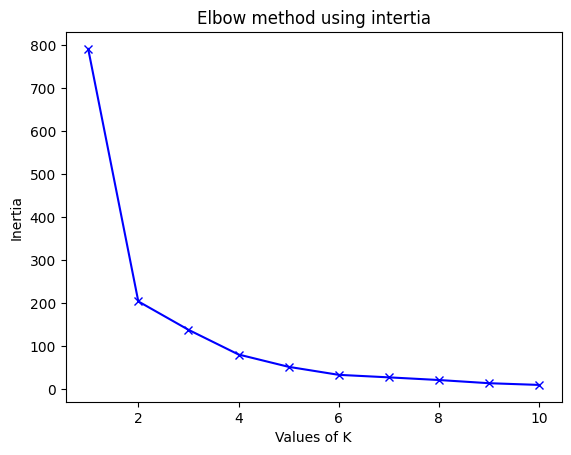

In [30]:
#Use elbow method with inertia in order to set the number of clusters
elbow_method(data_pca, 1,11)

In [31]:
#Fit the KMeans model with 4 clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans = kmeans.fit(data_pca)

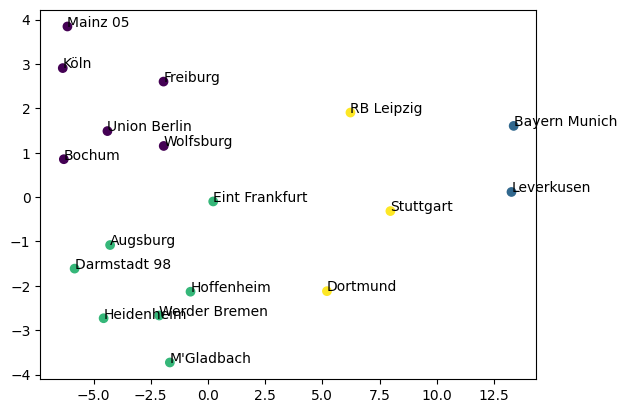

In [32]:
#Visualize the teams within the clusters
Visualize_PCA_2(data_pca, data_norm, kmeans.labels_)

In [33]:
#Make clusters table
teams = data_norm.index
labels = kmeans.labels_
clusters = pd.DataFrame({'Team':teams, 'cluster':labels})
#display clusters
clusters

,Team,cluster
0,Leverkusen,1
1,Bayern Munich,1
2,Stuttgart,3
3,Dortmund,3
4,RB Leipzig,3
5,Eint Frankfurt,2
6,Freiburg,0
7,Hoffenheim,2
8,Heidenheim,2
9,Werder Bremen,2


In [34]:
#Scrape the games table from fbref (if needed load here games_bundes.xlsx)
games = gamesTable(urlGames, gamesTableID)
games

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Venue,Referee,Match Report,homeScore,awayScore,HomeCluster,AwayCluster,Result
0,1.0,Fri,2023-08-18,20:30,Werder Bremen,0.6,0–4,2.8,Bayern Munich,Wohninvest Weserstadion,Felix Zwayer,Match Report,0,4,2,1,A
1,1.0,Sat,2023-08-19,15:30,Leverkusen,1.4,3–2,1.6,RB Leipzig,BayArena,Felix Brych,Match Report,3,2,1,3,H
2,1.0,Sat,2023-08-19,15:30,Wolfsburg,2.2,2–0,1.2,Heidenheim,Volkswagen Arena,Florian Badstübner,Match Report,2,0,0,2,H
3,1.0,Sat,2023-08-19,15:30,Stuttgart,3.0,5–0,0.8,Bochum,MHPArena,Daniel Siebert,Match Report,5,0,3,0,H
4,1.0,Sat,2023-08-19,15:30,Augsburg,2.3,4–4,1.7,M'Gladbach,WWK Arena,Daniel Schlager,Match Report,4,4,2,2,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,21.0,Sat,2024-02-10,15:30,Eint Frankfurt,2.4,1–1,1.5,Bochum,Deutsche Bank Park,Sven Jablonski,Match Report,1,1,2,0,D
185,21.0,Sat,2024-02-10,15:30,Augsburg,0.7,2–2,1.3,RB Leipzig,WWK Arena,Benjamin Brand,Match Report,2,2,2,3,D
186,21.0,Sat,2024-02-10,18:30,Leverkusen,1.3,3–0,0.6,Bayern Munich,BayArena,Felix Zwayer,Match Report,3,0,1,1,H
187,21.0,Sun,2024-02-11,15:30,Stuttgart,1.9,3–1,1.4,Mainz 05,MHPArena,Deniz Aytekin,Match Report,3,1,3,0,H


In [35]:
#Make the df that is going to be the input for the model.
#This df contains the history of each team before the every game and the result they got
#wk = week game
#Home = Home team
#Away = Away team
#Result = Result from the math H(Home wins), A(Away wins), D(Draw)
#HomeCluster = Cluster of home team
#AwayCluster = Cluster of away team
#HomeWinsCP = Proportion of home wins from home team vs away cluster teams
#HomeLosesCP = Proportion of home defeats from home team vs away cluster teams
#HomeDrawsCP = Proportion of home draws from home team vs away cluster teams
#HomeClsutersWinsP = Proportion of home wins from home cluster teams vs away cluster teams
#HomeClustersLosesP = Proportion of home defeats from home cluster vs away cluster teams
#HomeClustersDrawsCP = Proportion of home draws from home cluster team vs away cluster teams
#AwayWinsCP = Proportion of away wins from away team vs home cluster teams
#AwayLosesCP = Proportion of away defeats from away team vs home cluster teams
#AwayDrawsCP = Proportion of away draws from away team vs home cluster teams
#AwayClsutersWinsP = Proportion of away wins from away cluster teams vs home cluster teams
#AwayClustersLosesP = Proportion of away defeats from away cluster vs home cluster teams
#AwayClustersDrawsCP = Proportion of away draws from away cluster team vs home cluster teams
#OverAllWinsCPH = Proportion of overall wins from home team vs away cluster teams
#OverAllLosesCPH = Proportion of overall defeats from home team vs away cluster teams
#OverAllDrawsCPH = Proportion of overall draws from home team vs away cluster teams
#OverAllClsutersWinsPH = Proportion of overall wins from home cluster teams vs away cluster teams
#OverAllClustersLosesPH = Proportion of overall defeats from home cluster teams vs away cluster teams
#OverALLClustersDrawsPH = Proportion of overall draws from home cluster teams vs away cluster teams
#OverAllWinsCPA = Proportion of overall wins from away team vs home cluster teams
#OverAllLosesCPA = Proportion of overall defeats from away team vs home cluster teams
#OverAllDrawsCPA = Proportion of overall draws from away team vs home cluster teams
#OverAllClsutersWinsPA = Proportion of overall wins from away cluster teams vs home cluster teams
#OverAllClustersLosesPA = Proportion of overall defeats from away cluster teams vs home cluster teams
#OverALLClustersDrawsPA = Proportion of overall draws from away cluster teams vs home cluster teams
dfprueba = base_data(games, 11, n_clusters)
dfprueba

,Wk,Home,Away,Result,HomeCluster,AwayCluster,HomeWinsCP,HomeLosesCP,HomeDrawsCP,HomeClustersWinsP,HomeClustersLosesP,HomeClustersDrawsP,AwayWinsCP,AwayLosesCP,AwayDrawsCP,AwayClustersWinsP,AwayClustersLosesP,AwayClustersDrawsP,OverAllWinsCPH,OverAllLosesCPH,OverAllDrawsCPH,OverallClustersWinsPH,OverallClustersLosesPH,OverallClustersDrawsPH,OverAllWinsCPA,OverAllLosesCPA,OverAllDrawsCPA,OverallClustersWinsPA,OverallClustersLosesPA,OverallClustersDrawsPA,ResultN
90,11.0,M'Gladbach,Wolfsburg,H,2,0,0.0,0.00,0.00,0.500000,0.214286,0.285714,0.000000,1.000000,0.000000,0.214286,0.500000,0.285714,0.000000,0.000000,0.000000,0.392857,0.285714,0.321429,0.400000,0.400000,0.200000,0.285714,0.392857,0.321429,0
91,11.0,Augsburg,Hoffenheim,D,2,2,0.0,0.50,0.50,0.416667,0.416667,0.166667,1.000000,0.000000,0.000000,0.416667,0.416667,0.166667,0.333333,0.333333,0.333333,0.416667,0.416667,0.166667,0.666667,0.333333,0.000000,0.416667,0.416667,0.166667,1
92,11.0,Stuttgart,Dortmund,H,3,3,0.0,0.00,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0
93,11.0,Bayern Munich,Heidenheim,H,1,2,0.0,0.00,0.00,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0
94,11.0,Darmstadt 98,Mainz 05,D,2,0,0.0,1.00,0.00,0.500000,0.214286,0.285714,0.000000,0.666667,0.333333,0.214286,0.500000,0.285714,0.000000,1.000000,0.000000,0.392857,0.285714,0.321429,0.000000,0.500000,0.500000,0.285714,0.392857,0.321429,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,21.0,Eint Frankfurt,Bochum,D,2,0,0.0,0.00,0.00,0.480000,0.200000,0.320000,0.250000,0.250000,0.500000,0.200000,0.480000,0.320000,0.000000,0.000000,0.000000,0.352941,0.274510,0.372549,0.125000,0.250000,0.625000,0.274510,0.352941,0.372549,1
185,21.0,Augsburg,RB Leipzig,D,2,3,0.0,0.00,1.00,0.181818,0.454545,0.363636,0.000000,0.000000,0.000000,0.454545,0.181818,0.363636,0.000000,0.666667,0.333333,0.181818,0.590909,0.227273,0.000000,0.000000,0.000000,0.590909,0.181818,0.227273,1
186,21.0,Leverkusen,Bayern Munich,H,1,1,0.0,0.00,0.00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0
187,21.0,Stuttgart,Mainz 05,H,3,0,1.0,0.00,0.00,0.833333,0.000000,0.166667,0.000000,0.000000,1.000000,0.000000,0.833333,0.166667,0.875000,0.125000,0.000000,0.739130,0.130435,0.130435,0.333333,0.333333,0.333333,0.130435,0.739130,0.130435,0


In [36]:
#Get the variables to train the model
X = dfprueba.drop(['Wk', 'Home', 'Away', 'Result', 'HomeCluster', 'AwayCluster', 'ResultN'],axis=1).values
y = dfprueba['ResultN'].values
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 0)

In [37]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "SVM": SVC(random_state=0),
    "KNN": KNeighborsClassifier()
}

# Dictionary to hold cross-validation scores
cv_scores = {}

# Perform 10-fold cross-validation for each model and store the mean accuracy
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    cv_scores[model_name] = scores.mean()

# Display the mean accuracy for each model
cv_scores

{'Random Forest': 0.5566666666666668,
 'SVM': 0.5666666666666667,
 'KNN': 0.4455555555555556}

Although SVM seems slightly better, I'm going to choose Random Forest Classifier.

In [38]:
# Prepare the feature matrix X and the target vector y
X = dfprueba.drop(['Wk', 'Home', 'Away', 'Result', 'HomeCluster', 'AwayCluster', 'ResultN'], axis=1).values
y = dfprueba['ResultN'].values

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Perform 10-fold cross-validation and store the mean accuracy
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
mean_accuracy = scores.mean()

# Display the mean accuracy
mean_accuracy

0.5566666666666668

In [39]:
# Fit the RandomForestClassifier model on the entire dataset
model.fit(X, y)

# Make predictions using the fitted model
predictions = model.predict(X)

# Display the predictions
dfprueba['pred'] = predictions

In [40]:
#Get the next week game and calculte the data to run the model, the last argument of the function is the weekgame (if needed use baseprueba2_bundes.xlsx here)
baseprueba2 = NextGames(urlGames, gamesTableID, 
                        n_clusters)

In [41]:
#Get the variables for the model
X = baseprueba2.drop(['Wk', 'Home', 'Away', 'Result', 'HomeCluster', 'AwayCluster', 'ResultN'],axis=1).values

In [42]:
#Make predictions
ypred2 = model.predict(X)
#append to dataset
baseprueba2['pred'] = ypred2
baseprueba2

,Wk,Home,Away,Result,HomeCluster,AwayCluster,HomeWinsCP,HomeLosesCP,HomeDrawsCP,HomeClustersWinsP,HomeClustersLosesP,HomeClustersDrawsP,AwayWinsCP,AwayLosesCP,AwayDrawsCP,AwayClustersWinsP,AwayClustersLosesP,AwayClustersDrawsP,OverAllWinsCPH,OverAllLosesCPH,OverAllDrawsCPH,OverallClustersWinsPH,OverallClustersLosesPH,OverallClustersDrawsPH,OverAllWinsCPA,OverAllLosesCPA,OverAllDrawsCPA,OverallClustersWinsPA,OverallClustersLosesPA,OverallClustersDrawsPA,ResultN,pred
0,22.0,Köln,Werder Bremen,NaN,0,2,0.4,0.200000,0.400000,0.346154,0.230769,0.423077,0.000000,0.000000,0.000000,0.230769,0.346154,0.423077,0.333333,0.222222,0.444444,0.264151,0.339623,0.396226,0.000000,0.000000,0.000000,0.339623,0.264151,0.396226,2,0
1,22.0,Mainz 05,Augsburg,NaN,0,2,0.0,0.666667,0.333333,0.346154,0.230769,0.423077,0.000000,0.250000,0.750000,0.230769,0.346154,0.423077,0.000000,0.555556,0.444444,0.264151,0.339623,0.396226,0.285714,0.142857,0.571429,0.339623,0.264151,0.396226,2,2
2,22.0,Hoffenheim,Union Berlin,NaN,2,0,0.4,0.200000,0.400000,0.444444,0.185185,0.370370,0.000000,0.000000,0.000000,0.185185,0.444444,0.370370,0.444444,0.222222,0.333333,0.339623,0.264151,0.396226,0.000000,0.000000,0.000000,0.264151,0.339623,0.396226,2,0
3,22.0,Darmstadt 98,Stuttgart,NaN,2,3,0.0,1.000000,0.000000,0.166667,0.416667,0.416667,0.333333,0.666667,0.000000,0.416667,0.166667,0.416667,0.000000,1.000000,0.000000,0.173913,0.565217,0.260870,0.571429,0.428571,0.000000,0.565217,0.173913,0.260870,2,1
4,22.0,Wolfsburg,Dortmund,NaN,0,3,1.0,0.000000,0.000000,0.272727,0.636364,0.090909,0.666667,0.000000,0.333333,0.636364,0.272727,0.090909,0.333333,0.666667,0.000000,0.120000,0.760000,0.120000,0.777778,0.000000,0.222222,0.760000,0.120000,0.120000,2,2
5,22.0,Heidenheim,Leverkusen,NaN,2,1,0.0,0.000000,0.000000,0.111111,0.888889,0.000000,1.000000,0.000000,0.000000,0.888889,0.111111,0.000000,0.000000,1.000000,0.000000,0.105263,0.842105,0.052632,0.888889,0.000000,0.111111,0.842105,0.105263,0.052632,2,2
6,22.0,RB Leipzig,M'Gladbach,NaN,3,2,0.0,0.000000,0.000000,0.727273,0.181818,0.090909,0.000000,0.000000,0.000000,0.181818,0.727273,0.090909,0.000000,0.000000,0.000000,0.565217,0.173913,0.260870,0.000000,0.000000,0.000000,0.173913,0.565217,0.260870,2,0
7,22.0,Freiburg,Eint Frankfurt,NaN,0,2,0.6,0.000000,0.400000,0.346154,0.230769,0.423077,0.000000,0.000000,0.000000,0.230769,0.346154,0.423077,0.444444,0.222222,0.333333,0.264151,0.339623,0.396226,0.000000,0.000000,0.000000,0.339623,0.264151,0.396226,2,0
8,22.0,Bochum,Bayern Munich,NaN,0,1,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2,2


In [43]:
#See punctual predictions
baseprueba2[['Home', 'Away', 'pred']]

,Home,Away,pred
0,Köln,Werder Bremen,0
1,Mainz 05,Augsburg,2
2,Hoffenheim,Union Berlin,0
3,Darmstadt 98,Stuttgart,1
4,Wolfsburg,Dortmund,2
5,Heidenheim,Leverkusen,2
6,RB Leipzig,M'Gladbach,0
7,Freiburg,Eint Frankfurt,0
8,Bochum,Bayern Munich,2


In [44]:
# Predicting the probabilities for the test set using Random Forest
y_pred_proba_rf = model.predict_proba(X)

# Displaying the probabilities for the first few instances using Random Forest
y_pred_proba_rf

array([[0.76   , 0.16   , 0.08   ],
       [0.35   , 0.22   , 0.43   ],
       [0.61   , 0.33   , 0.06   ],
       [0.16625, 0.46   , 0.37375],
       [0.25   , 0.32   , 0.43   ],
       [0.09   , 0.     , 0.91   ],
       [0.58   , 0.09   , 0.33   ],
       [0.67   , 0.27   , 0.06   ],
       [0.19   , 0.     , 0.81   ]])

In [45]:
#Add probabilities to dataset
baseprueba2['H'] = y_pred_proba_rf[:,0].round(2)
baseprueba2['D'] = y_pred_proba_rf[:,1].round(2)
baseprueba2['A'] = y_pred_proba_rf[:,2].round(2)

In [46]:
# Calculating odds and rounding to two decimal
baseprueba2['H_O'] = (1/baseprueba2['H']).round(2)
baseprueba2['D_O'] = (1/baseprueba2['D']).round(2)
baseprueba2['A_O'] = (1/baseprueba2['A']).round(2)

In [47]:
#Pred is the most probable outcome (0=HomeWin, 1=Draw, 2=AwayWin)
#H = probability of home win
#D = probability of draw
#A probability of away win
#*_O calculated odds from probabilities
baseprueba2[['Home', 'Away', 'pred', 'H', 'D', 'A', 'H_O', 'D_O', 'A_O']]

,Home,Away,pred,H,D,A,H_O,D_O,A_O
0,Köln,Werder Bremen,0,0.76,0.16,0.08,1.32,6.25,12.50
1,Mainz 05,Augsburg,2,0.35,0.22,0.43,2.86,4.55,2.33
2,Hoffenheim,Union Berlin,0,0.61,0.33,0.06,1.64,3.03,16.67
3,Darmstadt 98,Stuttgart,1,0.17,0.46,0.37,5.88,2.17,2.70
4,Wolfsburg,Dortmund,2,0.25,0.32,0.43,4.00,3.12,2.33
5,Heidenheim,Leverkusen,2,0.09,0.00,0.91,11.11,inf,1.10
6,RB Leipzig,M'Gladbach,0,0.58,0.09,0.33,1.72,11.11,3.03
7,Freiburg,Eint Frankfurt,0,0.67,0.27,0.06,1.49,3.70,16.67
8,Bochum,Bayern Munich,2,0.19,0.00,0.81,5.26,inf,1.23


![Colonia-WerderBremen](Colonia-WerderBremen.jpeg)


![Wolfsburgo-Dortmund](Wolfsburgo-Dortmund.jpeg)


![Mainz-Augsburgo](Mainz-Augsburgo.jpeg)


![Hoffenheim-UnionBerlin](Hoffenheim-UnionBerlin.jpeg)


![Darmstadt-Stuttgart](Darmstadt-Stuttgart.jpeg)


![Heidenheim-Bayer](Heidenheim-Bayer.jpeg)


![Bochum-Bayern](Bochum-Bayern.jpeg)


![Freiburgo-Frankfurt](Freiburgo-Frankfurt.jpeg)


![Leipzig-Monchengladbach](Leipzig-Monchengladbach.jpeg)
